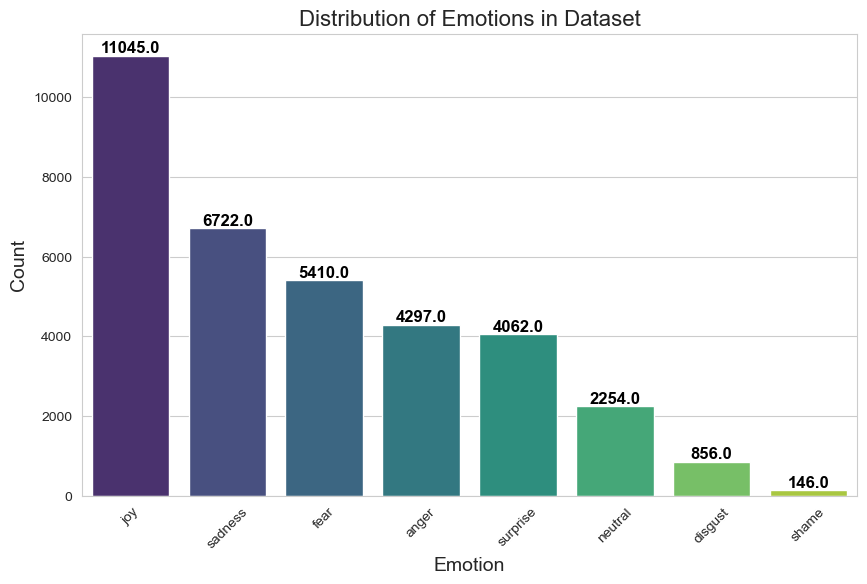

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "emotion_dataset_raw.csv"  # Update this with the correct path if needed
df = pd.read_csv(file_path)

# Set plot style
sns.set_style("whitegrid")

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x="Emotion", order=df["Emotion"].value_counts().index, palette="viridis")

# Annotate the bars with their counts
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Labels and title
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Emotions in Dataset", fontsize=16)
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [5]:
import pandas as pd
import numpy as np
from gensim.models import FastText
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Replaced DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import joblib

# Step 1: Load the dataset
df = pd.read_csv("emotion_dataset_raw.csv")  # Save your data as emotion_data.csv
print("Emotion data loaded.")

# Step 2: Verify columns
expected_columns = ["Emotion", "Text"]
if not all(col in df.columns for col in expected_columns):
    raise ValueError(f"Dataset must have columns: {expected_columns}")

# Step 3: Prepare text data
sentences = df["Text"].tolist()

# Step 4: Train FastText model
fasttext_model = FastText(sentences=[str(text).split() for text in sentences], 
                         vector_size=100, window=5, min_count=1, workers=4)
fasttext_model.save("fasttext_emotion_model.bin")
print("FastText model trained and saved as 'fasttext_emotion_model.bin'.")

# Step 5: Convert text to FastText vectors (average of word vectors)
def text_to_vec(text):
    words = str(text).split()
    vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(fasttext_model.vector_size)

encoded_data = [text_to_vec(text) for text in df["Text"]]
vector_columns = [f"Vec_{i}" for i in range(fasttext_model.vector_size)]
encoded_df = pd.DataFrame(encoded_data, columns=vector_columns)
encoded_df["Emotion"] = df["Emotion"]
print("Text encoded with FastText vectors.")

# Step 6: Add weighted average context features
def create_context_features_weighted(df, vector_cols):
    text_vectors = df[vector_cols].values
    n_texts = len(text_vectors)
    new_features = []
    for i in range(n_texts):
        current_vec = text_vectors[i]
        prev_vec = text_vectors[i - 1] if i > 0 else np.zeros(len(vector_cols))
        next_vec = text_vectors[i + 1] if i < n_texts - 1 else np.zeros(len(vector_cols))
        context_vec = (0.7 * prev_vec + 0.3 * next_vec)  # Weighted average, favoring previous
        new_feat = np.hstack([current_vec, context_vec])
        new_features.append(new_feat)
    return new_features

context_features = create_context_features_weighted(encoded_df, vector_columns)
context_columns = [f"Context_Vec_{i}" for i in range(fasttext_model.vector_size)]
new_feature_columns = vector_columns + context_columns
context_df = pd.DataFrame(context_features, columns=new_feature_columns)
final_df = pd.concat([encoded_df[["Emotion"]], context_df], axis=1)
print("Weighted average context features added.")

# Step 7: Add character N-grams
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2), binary=True)
vectorizer.fit(df['Text'])
joblib.dump(vectorizer, "emotion_vectorizer.pkl")
bigram_features = vectorizer.transform(df['Text']).toarray()
bigram_df = pd.DataFrame(bigram_features, columns=['bigram_' + col for col in vectorizer.get_feature_names_out()])
final_df = pd.concat([final_df, bigram_df], axis=1)
final_df.to_csv("fasttext_context_ngrams_emotion_encoded.csv", index=False)
print(f"Character N-grams (bigrams) added and vectorizer saved. Total columns: {final_df.shape[1]}")

# Step 8: Encode emotions
label_encoder = LabelEncoder()
final_df["Emotion"] = label_encoder.fit_transform(final_df["Emotion"])
joblib.dump(label_encoder, "emotion_label_encoder.pkl")
final_df.to_csv("fasttext_context_ngrams_emotion_encoded_classification.csv", index=False)
print("Emotions encoded and label encoder saved.")
print(f"Unique Emotions Mapped: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Step 9: Prepare features
X_features = final_df.drop(columns=["Emotion"])
y = final_df["Emotion"]

# Step 10: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
joblib.dump(scaler, "emotion_scaler.pkl")
print("Scaler fitted and saved.")

# Step 11: Apply LDA
n_classes = len(np.unique(y))
n_features = X_features.shape[1]
n_components = min(n_classes - 1, n_features)
lda = LDA(n_components=n_components)
X_lda = lda.fit_transform(X_scaled, y)
joblib.dump(lda, "emotion_lda.pkl")
print("LDA fitted and saved.")

# Step 12: Create final DataFrame with LDA features
lda_columns = [f"LDA_{i+1}" for i in range(n_components)]
lda_df = pd.DataFrame(X_lda, columns=lda_columns)
lda_final_df = pd.concat([pd.Series(y, name="Emotion"), lda_df], axis=1)
lda_final_df.to_csv("lda_fasttext_context_ngrams_emotion_encoded_classification.csv", index=False)
print(f"LDA applied, reduced to {n_components} components.")

# Step 13: Prepare data for training
X = lda_final_df.drop(columns=["Emotion"])
y = lda_final_df["Emotion"]

# Step 14: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 15: Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(f"Class Weights: {class_weights}")

# Step 16: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=28, criterion='entropy', 
                            class_weight=class_weights, min_samples_leaf=1, 
                            min_samples_split=2, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
joblib.dump(rf, "emotion_rf_model.pkl")
y_pred = rf.predict(X_test)

print("Results for Random Forest:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Random Forest trained and saved as 'emotion_rf_model.pkl'.")

# Step 17: Calculate F1-score
score = f1_score(y_test, y_pred, average='weighted')
print("Random Forest F1 Score: {:.2f}".format(score))

# Step 18: Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_y_true = []
all_y_pred = []

for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    rf_cv = RandomForestClassifier(n_estimators=100, max_depth=28, criterion='entropy', 
                                   class_weight=class_weights, min_samples_leaf=1, 
                                   min_samples_split=2, random_state=42, n_jobs=-1)
    rf_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = rf_cv.predict(X_test_cv)
    
    all_y_true.extend(y_test_cv)
    all_y_pred.extend(y_pred_cv)

print("\nCross Validation Results:")
print(classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_))

# Step 19: Print final info
print(f"Total columns in original dataset: {final_df.shape[1]}")
print(f"Total columns in LDA dataset: {lda_final_df.shape[1]}")


Emotion data loaded.
FastText model trained and saved as 'fasttext_emotion_model.bin'.
Text encoded with FastText vectors.
Weighted average context features added.
Character N-grams (bigrams) added and vectorizer saved. Total columns: 3851
Emotions encoded and label encoder saved.
Unique Emotions Mapped: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'neutral': 4, 'sadness': 5, 'shame': 6, 'surprise': 7}
Scaler fitted and saved.
LDA fitted and saved.
LDA applied, reduced to 7 components.
Class Weights: {0: 1.0052369257440046, 1: 5.319762996941896, 2: 0.8079714352066883, 3: 0.393967274374363, 4: 1.9622814438804286, 5: 0.6448795180722892, 6: 28.285569105691057, 7: 1.057484802431611}
Results for Random Forest:
              precision    recall  f1-score   support

       anger       0.58      0.56      0.57       836
     disgust       0.66      0.43      0.52       202
        fear       0.68      0.66      0.67      1104
         joy       0.66      0.76      0.71      2214
     neutra

In [13]:
import pandas as pd
import numpy as np
from gensim.models import FastText
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load all the pre-trained models and encoders
def load_models():
    fasttext_model = FastText.load("fasttext_emotion_model.bin")
    vectorizer = joblib.load("emotion_vectorizer.pkl")
    label_encoder = joblib.load("emotion_label_encoder.pkl")
    scaler = joblib.load("emotion_scaler.pkl")
    lda = joblib.load("emotion_lda.pkl")
    rf_model = joblib.load("emotion_rf_model.pkl")
    
    return fasttext_model, vectorizer, label_encoder, scaler, lda, rf_model

# Function to convert text to FastText vector
def text_to_vec(text, fasttext_model):
    words = str(text).split()
    vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(fasttext_model.vector_size)

# Function to create context features (simplified for single input)
def create_context_features_weighted(vector, vector_size):
    prev_vec = np.zeros(vector_size)
    next_vec = np.zeros(vector_size)
    context_vec = (0.7 * prev_vec + 0.3 * next_vec)
    return np.hstack([vector, context_vec])

# Function to process input and predict emotion
def predict_emotion(text, fasttext_model, vectorizer, label_encoder, scaler, lda, rf_model):
    # Step 1: Convert text to FastText vector
    fasttext_vec = text_to_vec(text, fasttext_model)
    vector_size = fasttext_model.vector_size
    
    # Step 2: Add context features
    context_features = create_context_features_weighted(fasttext_vec, vector_size)
    feature_columns = [f"Vec_{i}" for i in range(vector_size)] + \
                     [f"Context_Vec_{i}" for i in range(vector_size)]
    
    # Step 3: Add character bigrams
    bigram_features = vectorizer.transform([text]).toarray()
    bigram_columns = ['bigram_' + col for col in vectorizer.get_feature_names_out()]
    
    # Step 4: Combine all features
    features_df = pd.DataFrame([context_features], columns=feature_columns)
    bigram_df = pd.DataFrame(bigram_features, columns=bigram_columns)
    combined_df = pd.concat([features_df, bigram_df], axis=1)
    
    # Step 5: Scale features
    X_scaled = scaler.transform(combined_df)
    
    # Step 6: Apply LDA
    X_lda = lda.transform(X_scaled)
    
    # Step 7: Predict emotion
    prediction = rf_model.predict(X_lda)
    emotion = label_encoder.inverse_transform(prediction)[0]
    
    return emotion

# Main execution with user input
def main():
    # Load all models
    print("Loading models...")
    try:
        fasttext_model, vectorizer, label_encoder, scaler, lda, rf_model = load_models()
        print("Models loaded successfully!")
    except Exception as e:
        print(f"Failed to load models: {str(e)}")
        return
    
    while True:
        # Get user input
        user_input = input("\nEnter text to analyze emotion (or 'quit' to exit): ")
        
        # Check if user wants to quit
        if user_input.lower() == 'quit':
            print("Exiting program...")
            break
        
        if not user_input.strip():
            print("Please enter some text!")
            continue
            
        try:
            # Predict emotion
            emotion = predict_emotion(
                user_input, fasttext_model, vectorizer, 
                label_encoder, scaler, lda, rf_model
            )
            
            # Display results
            print(f"\nInput Text: '{user_input}'")
            print(f"Predicted Emotion: {emotion}")
                
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            print("Please try again.")

if __name__ == "__main__":
    main()

Loading models...
Models loaded successfully!



Enter text to analyze emotion (or 'quit' to exit):  i am feeling amazing



Input Text: 'i am feeling amazing'
Predicted Emotion: sadness



Enter text to analyze emotion (or 'quit' to exit):  quit


Exiting program...
